# 🚗 Entrenamiento YOLOv8 para Detección de Partes de Vehículos (TFM)

## Objetivo del Experimento
Entrenar un modelo YOLOv8 optimizado para detectar **15 clases específicas** de partes de vehículos usando un dataset balanceado y hiperparámetros optimizados mediante tuning automático.

## Metodología Científica
1. **Preparación de datos**: Dataset balanceado con oversampling y augmentación
2. **Optimización**: Hiperparámetros previamente optimizados con `model.tune()`
3. **Entrenamiento**: YOLOv8m con configuración robusta y early stopping
4. **Evaluación**: Métricas completas en conjunto de test independiente
5. **Análisis**: Convergencia, distribución por clase y casos de fallo

## Configuración del Experimento
- **Arquitectura**: YOLOv8 Medium (22.5M parámetros)
- **Dataset**: 15 clases balanceadas de partes vehiculares
- **Hiperparámetros**: Optimizados mediante búsqueda automática
- **Hardware**: Google Colab GPU (Tesla T4/V100)
- **Reproducibilidad**: Semilla fija, logs completos

## Métricas Objetivo
- **mAP@0.5**: >0.75 (objetivo principal)
- **mAP@0.5:0.95**: >0.45 (evaluación estricta)
- **Balance por clase**: CV < 0.3 (coeficiente de variación)

---

In [3]:
# --- Paso 0: Instalación de dependencias ---
print("🔧 Instalando dependencias necesarias...")

# Instalar ultralytics (YOLOv8)
!pip install ultralytics

# Instalar otras dependencias que puedan faltar
!pip install seaborn

# Verificar instalaciones
import subprocess
import sys

def check_package(package_name):
    try:
        __import__(package_name)
        return True
    except ImportError:
        return False

packages_to_check = [
    ('ultralytics', 'ultralytics'),
    ('cv2', 'opencv-python'),
    ('seaborn', 'seaborn'),
    ('matplotlib', 'matplotlib'),
    ('pandas', 'pandas'),
    ('numpy', 'numpy'),
    ('yaml', 'PyYAML')
]

print("\n📦 Verificando dependencias:")
for package, pip_name in packages_to_check:
    if check_package(package):
        print(f"✅ {package} instalado correctamente")
    else:
        print(f"❌ {package} no encontrado, instalando...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])

print("\n🎉 Todas las dependencias están listas!")
print("🔄 Ahora puedes ejecutar las siguientes celdas.")

🔧 Instalando dependencias necesarias...

📦 Verificando dependencias:
✅ ultralytics instalado correctamente
✅ cv2 instalado correctamente
✅ seaborn instalado correctamente
✅ matplotlib instalado correctamente
✅ pandas instalado correctamente
✅ numpy instalado correctamente
✅ yaml instalado correctamente

🎉 Todas las dependencias están listas!
🔄 Ahora puedes ejecutar las siguientes celdas.


In [4]:
# --- Paso 1: Configuración del entorno ---
import os
import yaml
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
from google.colab import drive, files
import datetime
import glob
import json
from pathlib import Path

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")

print(f"🚀 Fecha de ejecución: {datetime.datetime.now()}")

# Verificar versión de ultralytics de forma más robusta
try:
    import ultralytics
    version = getattr(ultralytics, '__version__', 'unknown')
    print(f"📊 Versión de Ultralytics: {version}")
except Exception as e:
    print(f"📊 Ultralytics instalado (versión no detectada: {e})")

print("📁 Montando Google Drive...")
drive.mount('/content/drive')

# Directorios de trabajo
DRIVE_PROJECT_PATH = '/content/drive/MyDrive/TFM_Proyecto_Modelos'
RESULTS_PATH = os.path.join(DRIVE_PROJECT_PATH, 'resultados_finales')
os.makedirs(DRIVE_PROJECT_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

print(f"✅ Directorio de trabajo: {DRIVE_PROJECT_PATH}")
print(f"✅ Directorio de resultados: {RESULTS_PATH}")

# Verificar GPU disponible
import torch
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"🚀 GPU detectada: {gpu_name} ({gpu_memory:.1f} GB)")

    # Información adicional de GPU
    print(f"🔧 CUDA disponible: {torch.version.cuda}")
    print(f"🔧 Dispositivos disponibles: {torch.cuda.device_count()}")
else:
    print("⚠️ No se detectó GPU. El entrenamiento será más lento.")

# Verificar espacio disponible en disco
import shutil
total, used, free = shutil.disk_usage('/content/')
print(f"💾 Espacio disponible: {free // (1024**3)} GB de {total // (1024**3)} GB")

# Establecer semilla para reproducibilidad
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
print(f"🎲 Semilla establecida: {SEED} (para reproducibilidad)")

print("\n✅ Configuración del entorno completada correctamente.")

🚀 Fecha de ejecución: 2025-09-10 17:44:05.359708
📊 Versión de Ultralytics: 8.3.198
📁 Montando Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Directorio de trabajo: /content/drive/MyDrive/TFM_Proyecto_Modelos
✅ Directorio de resultados: /content/drive/MyDrive/TFM_Proyecto_Modelos/resultados_finales
🚀 GPU detectada: NVIDIA A100-SXM4-80GB (79.3 GB)
🔧 CUDA disponible: 12.6
🔧 Dispositivos disponibles: 1
💾 Espacio disponible: 191 GB de 235 GB
🎲 Semilla establecida: 42 (para reproducibilidad)

✅ Configuración del entorno completada correctamente.


### **ACCIÓN REQUERIDA:**
Ejecuta esta celda para subir:
1. **Dataset balanceado** (archivo ZIP)
2. **hyp_tuned.yaml** (hiperparámetros optimizados)

In [7]:
# --- Paso 2: Subir archivos necesarios ---
print("📤 Sube los archivos necesarios:")
print("1. Dataset balanceado (archivo .zip)")
print("2. Archivo hyp_tuned.yaml con hiperparámetros optimizados")
print("\n⏳ Esperando archivos...")

uploaded = files.upload()

# Identificar archivos subidos
dataset_zip = None
hyp_file = None

for filename in uploaded.keys():
    if filename.endswith('.zip'):
        dataset_zip = filename
        file_size = len(uploaded[filename]) / (1024 * 1024)
        print(f"✅ Dataset ZIP: {dataset_zip} ({file_size:.1f} MB)")
    elif 'hyp' in filename.lower() and filename.endswith('.yaml'):
        hyp_file = filename
        print(f"✅ Hiperparámetros: {hyp_file}")

# Validaciones
if not dataset_zip:
    raise FileNotFoundError("❌ No se encontró archivo ZIP del dataset")
if not hyp_file:
    raise FileNotFoundError("❌ No se encontró archivo de hiperparámetros (.yaml)")

print("\n🎯 Todos los archivos subidos correctamente.")

# Guardar información de archivos subidos
upload_info = {
    'timestamp': datetime.datetime.now().isoformat(),
    'dataset_file': dataset_zip,
    'dataset_size_mb': file_size,
    'hyperparams_file': hyp_file
}

with open(os.path.join(RESULTS_PATH, 'upload_info.json'), 'w') as f:
    json.dump(upload_info, f, indent=2)

📤 Sube los archivos necesarios:
1. Dataset balanceado (archivo .zip)
2. Archivo hyp_tuned.yaml con hiperparámetros optimizados

⏳ Esperando archivos...


Saving dataset_final_unificado_dp.zip to dataset_final_unificado_dp (1).zip
Saving hyp_tuned_train_parts_detector.yaml to hyp_tuned_train_parts_detector (1).yaml
✅ Dataset ZIP: dataset_final_unificado_dp (1).zip (94.0 MB)
✅ Hiperparámetros: hyp_tuned_train_parts_detector (1).yaml

🎯 Todos los archivos subidos correctamente.


In [8]:
# --- Paso 3: Descomprimir y validar dataset ---
print(f"📦 Descomprimiendo {dataset_zip}...")

# Descomprimir dataset
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/')
print("✅ Dataset descomprimido.")

# Buscar archivo data.yaml automáticamente
data_yaml_path = None
dataset_root = None

for root, dirs, files in os.walk('/content/'):
    if 'data.yaml' in files:
        data_yaml_path = os.path.join(root, 'data.yaml')
        dataset_root = root
        break

if not data_yaml_path:
    raise FileNotFoundError("❌ No se encontró data.yaml en el dataset descomprimido.")

print(f"📋 Dataset root: {dataset_root}")
print(f"📋 data.yaml encontrado: {data_yaml_path}")

# Leer y validar data.yaml
with open(data_yaml_path, 'r') as file:
    data_yaml_content = yaml.safe_load(file)
    class_names = data_yaml_content.get('names', [])
    num_classes = len(class_names)

print(f"\n🎯 Dataset Information:")
print(f"  📊 Número de clases: {num_classes}")
print(f"  🏷️ Clases: {class_names}")

# Verificar estructura de directorios y contar archivos
splits = ['train', 'valid', 'test']
dataset_stats = {}

for split in splits:
    img_dir = os.path.join(dataset_root, split, 'images')
    lbl_dir = os.path.join(dataset_root, split, 'labels')

    if os.path.exists(img_dir) and os.path.exists(lbl_dir):
        img_count = len([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
        lbl_count = len([f for f in os.listdir(lbl_dir) if f.endswith('.txt')])

        dataset_stats[split] = {
            'images': img_count,
            'labels': lbl_count,
            'match': img_count == lbl_count
        }

        status = "✅" if img_count == lbl_count else "⚠️"
        print(f"  📁 {split}: {img_count} imágenes, {lbl_count} etiquetas {status}")
    else:
        dataset_stats[split] = {'images': 0, 'labels': 0, 'match': False}
        print(f"  ❌ {split}: Directorio no encontrado")

# Guardar estadísticas del dataset
dataset_info = {
    'num_classes': num_classes,
    'class_names': class_names,
    'dataset_root': dataset_root,
    'data_yaml_path': data_yaml_path,
    'splits_stats': dataset_stats,
    'validation_timestamp': datetime.datetime.now().isoformat()
}

with open(os.path.join(RESULTS_PATH, 'dataset_info.json'), 'w') as f:
    json.dump(dataset_info, f, indent=2)

print(f"\n📊 Información del dataset guardada en: {RESULTS_PATH}/dataset_info.json")

📦 Descomprimiendo dataset_final_unificado_dp (1).zip...
✅ Dataset descomprimido.
📋 Dataset root: /content/dataset_final_unificado_dp
📋 data.yaml encontrado: /content/dataset_final_unificado_dp/data.yaml

🎯 Dataset Information:
  📊 Número de clases: 15
  🏷️ Clases: ['parachoques_delantero', 'capo', 'faro_derecho', 'faro_izquierdo', 'parachoques_trasero', 'maletero', 'luz_trasera_derecha', 'luz_trasera_izquierda', 'puerta_delantera_izquierda', 'puerta_trasera_izquierda', 'espejo_lateral_izquierdo', 'puerta_delantera_derecha', 'puerta_trasera_derecha', 'espejo_lateral_derecho', 'rueda']
  📁 train: 2270 imágenes, 2270 etiquetas ✅
  📁 valid: 431 imágenes, 431 etiquetas ✅
  📁 test: 216 imágenes, 216 etiquetas ✅

📊 Información del dataset guardada en: /content/drive/MyDrive/TFM_Proyecto_Modelos/resultados_finales/dataset_info.json


In [9]:
# --- Paso 4: Configurar hiperparámetros optimizados ---
HYP_YAML_PATH = f'/content/{hyp_file}'

# Verificar y leer hiperparámetros
if not os.path.exists(HYP_YAML_PATH):
    raise FileNotFoundError(f"❌ No se encontró {HYP_YAML_PATH}")

with open(HYP_YAML_PATH, 'r') as f:
    hyp_content = yaml.safe_load(f)

print("⚙️ Hiperparámetros optimizados cargados:")
print("="*50)
for category, params in {
    'Optimización': ['lr0', 'lrf', 'momentum', 'weight_decay'],
    'Warmup': ['warmup_epochs', 'warmup_momentum'],
    'Loss': ['box', 'cls', 'dfl'],
    'Augmentación HSV': ['hsv_h', 'hsv_s', 'hsv_v'],
    'Augmentación Geométrica': ['degrees', 'translate', 'scale', 'fliplr'],
    'Augmentación Avanzada': ['mosaic', 'mixup', 'copy_paste']
}.items():
    print(f"\n{category}:")
    for param in params:
        if param in hyp_content:
            print(f"  {param}: {hyp_content[param]}")

print(f"\n✅ Archivo de hiperparámetros listo: {HYP_YAML_PATH}")

⚙️ Hiperparámetros optimizados cargados:

Optimización:
  lr0: 0.00967
  lrf: 0.01058
  momentum: 0.93566
  weight_decay: 0.00048

Warmup:
  warmup_epochs: 3.25814
  warmup_momentum: 0.76395

Loss:
  box: 8.22713
  cls: 0.52474
  dfl: 1.45577

Augmentación HSV:
  hsv_h: 0.01547
  hsv_s: 0.71951
  hsv_v: 0.29862

Augmentación Geométrica:
  degrees: 0.0
  translate: 0.12136
  scale: 0.52078
  fliplr: 0.47006

Augmentación Avanzada:
  mosaic: 1.0
  mixup: 0.0
  copy_paste: 0.0

✅ Archivo de hiperparámetros listo: /content/hyp_tuned_train_parts_detector (1).yaml


📊 Análisis de distribución del dataset balanceado:

TRAIN SET:
  Total objetos: 7109
  parachoques_delantero: 452 (6.4%)
  capo: 403 (5.7%)
  faro_derecho: 418 (5.9%)
  faro_izquierdo: 415 (5.8%)
  parachoques_trasero: 400 (5.6%)
  maletero: 360 (5.1%)
  luz_trasera_derecha: 477 (6.7%)
  luz_trasera_izquierda: 535 (7.5%)
  puerta_delantera_izquierda: 344 (4.8%)
  puerta_trasera_izquierda: 341 (4.8%)
  espejo_lateral_izquierdo: 440 (6.2%)
  puerta_delantera_derecha: 399 (5.6%)
  puerta_trasera_derecha: 392 (5.5%)
  espejo_lateral_derecho: 509 (7.2%)
  rueda: 1224 (17.2%)

VALID SET:
  Total objetos: 585
  parachoques_delantero: 46 (7.9%)
  capo: 45 (7.7%)
  faro_derecho: 42 (7.2%)
  faro_izquierdo: 50 (8.5%)
  parachoques_trasero: 25 (4.3%)
  maletero: 19 (3.2%)
  luz_trasera_derecha: 27 (4.6%)
  luz_trasera_izquierda: 37 (6.3%)
  puerta_delantera_izquierda: 32 (5.5%)
  puerta_trasera_izquierda: 29 (5.0%)
  espejo_lateral_izquierdo: 55 (9.4%)
  puerta_delantera_derecha: 23 (3.9%)
  puer

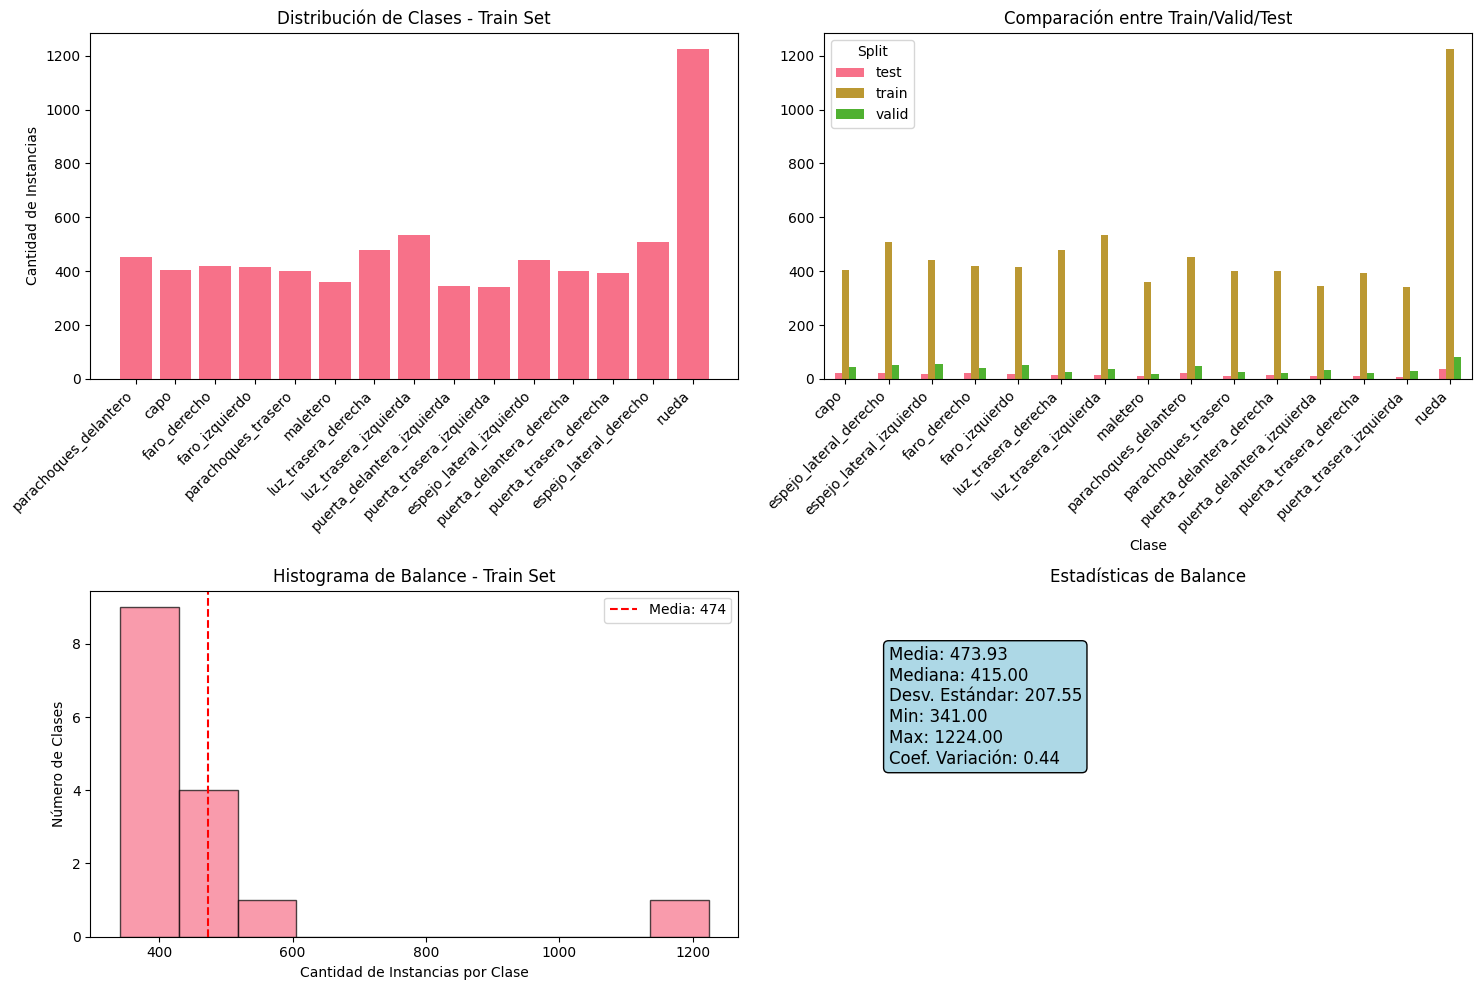


📊 Análisis guardado en: /content/drive/MyDrive/TFM_Proyecto_Modelos/resultados_finales/dataset_distribution_analysis.png


In [10]:
# --- Paso 5: Análisis del dataset balanceado ---
from collections import Counter

def analyze_dataset_distribution(labels_dir, class_names):
    """Analiza la distribución de clases en un directorio de etiquetas."""
    class_counts = Counter()
    total_objects = 0

    if not os.path.exists(labels_dir):
        return class_counts, total_objects

    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            label_path = os.path.join(labels_dir, label_file)
            with open(label_path, 'r') as f:
                for line in f:
                    try:
                        class_id = int(line.strip().split()[0])
                        class_counts[class_id] += 1
                        total_objects += 1
                    except (ValueError, IndexError):
                        continue

    return class_counts, total_objects

# Analizar distribución por split
print("📊 Análisis de distribución del dataset balanceado:")
print("="*60)

distribution_data = []

for split in ['train', 'valid', 'test']:
    labels_dir = os.path.join(dataset_root, split, 'labels')
    class_counts, total_objects = analyze_dataset_distribution(labels_dir, class_names)

    print(f"\n{split.upper()} SET:")
    print(f"  Total objetos: {total_objects}")

    for class_id in range(len(class_names)):
        count = class_counts.get(class_id, 0)
        percentage = (count / total_objects * 100) if total_objects > 0 else 0
        print(f"  {class_names[class_id]}: {count} ({percentage:.1f}%)")

        distribution_data.append({
            'Split': split,
            'Clase': class_names[class_id],
            'Clase_ID': class_id,
            'Cantidad': count,
            'Porcentaje': percentage
        })

# Crear DataFrame para análisis
df_distribution = pd.DataFrame(distribution_data)

# Visualizar distribución
plt.figure(figsize=(15, 10))

# Subplot 1: Distribución por split
plt.subplot(2, 2, 1)
train_data = df_distribution[df_distribution['Split'] == 'train']
plt.bar(train_data['Clase'], train_data['Cantidad'])
plt.title('Distribución de Clases - Train Set')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Cantidad de Instancias')

# Subplot 2: Comparación entre splits
plt.subplot(2, 2, 2)
pivot_data = df_distribution.pivot(index='Clase', columns='Split', values='Cantidad').fillna(0)
pivot_data.plot(kind='bar', ax=plt.gca())
plt.title('Comparación entre Train/Valid/Test')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Split')

# Subplot 3: Balance del train set
plt.subplot(2, 2, 3)
train_counts = train_data['Cantidad'].values
plt.hist(train_counts, bins=10, alpha=0.7, edgecolor='black')
plt.title('Histograma de Balance - Train Set')
plt.xlabel('Cantidad de Instancias por Clase')
plt.ylabel('Número de Clases')
plt.axvline(np.mean(train_counts), color='red', linestyle='--', label=f'Media: {np.mean(train_counts):.0f}')
plt.legend()

# Subplot 4: Estadísticas de balance
plt.subplot(2, 2, 4)
balance_stats = {
    'Media': np.mean(train_counts),
    'Mediana': np.median(train_counts),
    'Desv. Estándar': np.std(train_counts),
    'Min': np.min(train_counts),
    'Max': np.max(train_counts),
    'Coef. Variación': np.std(train_counts) / np.mean(train_counts)
}

stats_text = "\n".join([f"{k}: {v:.2f}" for k, v in balance_stats.items()])
plt.text(0.1, 0.5, stats_text, transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
plt.title('Estadísticas de Balance')
plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'dataset_distribution_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Análisis guardado en: {RESULTS_PATH}/dataset_distribution_analysis.png")

In [11]:
# --- Paso 6: Entrenamiento YOLOv8 optimizado ---
print("🚀 Iniciando entrenamiento con configuración optimizada para TFM...")
print("="*60)

# Configuración de entrenamiento optimizada
EXPERIMENT_NAME = 'Parts_Detector_TFM_Final'
EPOCHS = 150
PATIENCE = 50
BATCH_SIZE = 16
IMG_SIZE = 640

print(f"📋 Configuración de entrenamiento:")
print(f"  🎯 Experimento: {EXPERIMENT_NAME}")
print(f"  🔄 Épocas máximas: {EPOCHS}")
print(f"  ⏳ Paciencia: {PATIENCE}")
print(f"  📦 Batch size: {BATCH_SIZE}")
print(f"  🖼️ Tamaño imagen: {IMG_SIZE}")

# Cargar modelo base
model = YOLO('yolov8m.pt')
print(f"✅ Modelo YOLOv8m cargado")

# Aplicar hiperparámetros de forma robusta
print(f"⚙️ Aplicando hiperparámetros optimizados...")
hyp_args = {}
hyp_applied = 0
hyp_failed = 0

for key, value in hyp_content.items():
    try:
        # Validar que el valor sea numérico
        if isinstance(value, (int, float)) and not isinstance(value, bool):
            hyp_args[key] = value
            hyp_applied += 1
        else:
            print(f"⚠️ Saltando {key}: valor no numérico ({value})")
    except Exception as e:
        print(f"❌ Error aplicando {key}: {e}")
        hyp_failed += 1

print(f"✅ Hiperparámetros aplicados: {hyp_applied}")
print(f"⚠️ Hiperparámetros fallidos: {hyp_failed}")

# Mostrar hiperparámetros que se van a usar
print(f"\n📋 Hiperparámetros que se aplicarán:")
for key, value in hyp_args.items():
    print(f"  {key}: {value}")

# Iniciar entrenamiento
start_time = datetime.datetime.now()
print(f"\n🏁 Iniciando entrenamiento: {start_time}")

try:
    # Entrenamiento con manejo robusto de hiperparámetros
    results = model.train(
        data=data_yaml_path,
        # Parámetros principales (garantizados)
        epochs=EPOCHS,
        patience=PATIENCE,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        optimizer='AdamW',
        project=DRIVE_PROJECT_PATH,
        name=EXPERIMENT_NAME,
        exist_ok=True,
        save=True,
        save_period=25,
        plots=True,
        verbose=True,
        workers=2,
        seed=42,
        # Hiperparámetros optimizados (desempaquetados de forma segura)
        **hyp_args
    )

    end_time = datetime.datetime.now()
    training_duration = end_time - start_time

    print(f"\n🎉 Entrenamiento completado exitosamente!")
    print(f"⏱️ Duración total: {training_duration}")
    print(f"📁 Resultados guardados en: {DRIVE_PROJECT_PATH}/{EXPERIMENT_NAME}")

    # Guardar información del entrenamiento
    training_info = {
        'experiment_name': EXPERIMENT_NAME,
        'start_time': start_time.isoformat(),
        'end_time': end_time.isoformat(),
        'duration_seconds': training_duration.total_seconds(),
        'duration_formatted': str(training_duration),
        'epochs': EPOCHS,
        'patience': PATIENCE,
        'batch_size': BATCH_SIZE,
        'img_size': IMG_SIZE,
        'num_classes': num_classes,
        'class_names': class_names,
        'hyperparameters_applied': hyp_args,
        'hyperparameters_applied_count': hyp_applied,
        'hyperparameters_failed_count': hyp_failed,
        'training_successful': True
    }

    with open(os.path.join(RESULTS_PATH, 'training_info.json'), 'w') as f:
        json.dump(training_info, f, indent=2)

    print(f"📊 Información del entrenamiento guardada en: {RESULTS_PATH}/training_info.json")

except Exception as e:
    end_time = datetime.datetime.now()
    training_duration = end_time - start_time

    print(f"\n❌ Error durante el entrenamiento:")
    print(f"🔍 Error: {str(e)}")
    print(f"⏱️ Duración antes del error: {training_duration}")

    # Guardar información del error
    error_info = {
        'experiment_name': EXPERIMENT_NAME,
        'start_time': start_time.isoformat(),
        'error_time': end_time.isoformat(),
        'duration_before_error': training_duration.total_seconds(),
        'error_message': str(e),
        'hyperparameters_attempted': hyp_args,
        'training_successful': False
    }

    with open(os.path.join(RESULTS_PATH, 'training_error.json'), 'w') as f:
        json.dump(error_info, f, indent=2)

    print(f"📊 Información del error guardada en: {RESULTS_PATH}/training_error.json")

    # Re-lanzar el error para debugging
    raise

🚀 Iniciando entrenamiento con configuración optimizada para TFM...
📋 Configuración de entrenamiento:
  🎯 Experimento: Parts_Detector_TFM_Final
  🔄 Épocas máximas: 150
  ⏳ Paciencia: 50
  📦 Batch size: 16
  🖼️ Tamaño imagen: 640
✅ Modelo YOLOv8m cargado
⚙️ Aplicando hiperparámetros optimizados...
✅ Hiperparámetros aplicados: 24
⚠️ Hiperparámetros fallidos: 0

📋 Hiperparámetros que se aplicarán:
  lr0: 0.00967
  lrf: 0.01058
  momentum: 0.93566
  weight_decay: 0.00048
  warmup_epochs: 3.25814
  warmup_momentum: 0.76395
  box: 8.22713
  cls: 0.52474
  dfl: 1.45577
  hsv_h: 0.01547
  hsv_s: 0.71951
  hsv_v: 0.29862
  degrees: 0.0
  translate: 0.12136
  scale: 0.52078
  shear: 0.0
  perspective: 0.0
  flipud: 0.0
  fliplr: 0.47006
  bgr: 0.0
  mosaic: 1.0
  mixup: 0.0
  cutmix: 0.0
  copy_paste: 0.0

🏁 Iniciando entrenamiento: 2025-09-10 17:53:40.588798
Ultralytics 8.3.198 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=Tru

📈 Analizando curvas de entrenamiento...


/tmp/ipython-input-3103175741.py:83: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3103175741.py:84: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(RESULTS_PATH, 'training_curves_analysis.png'), dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


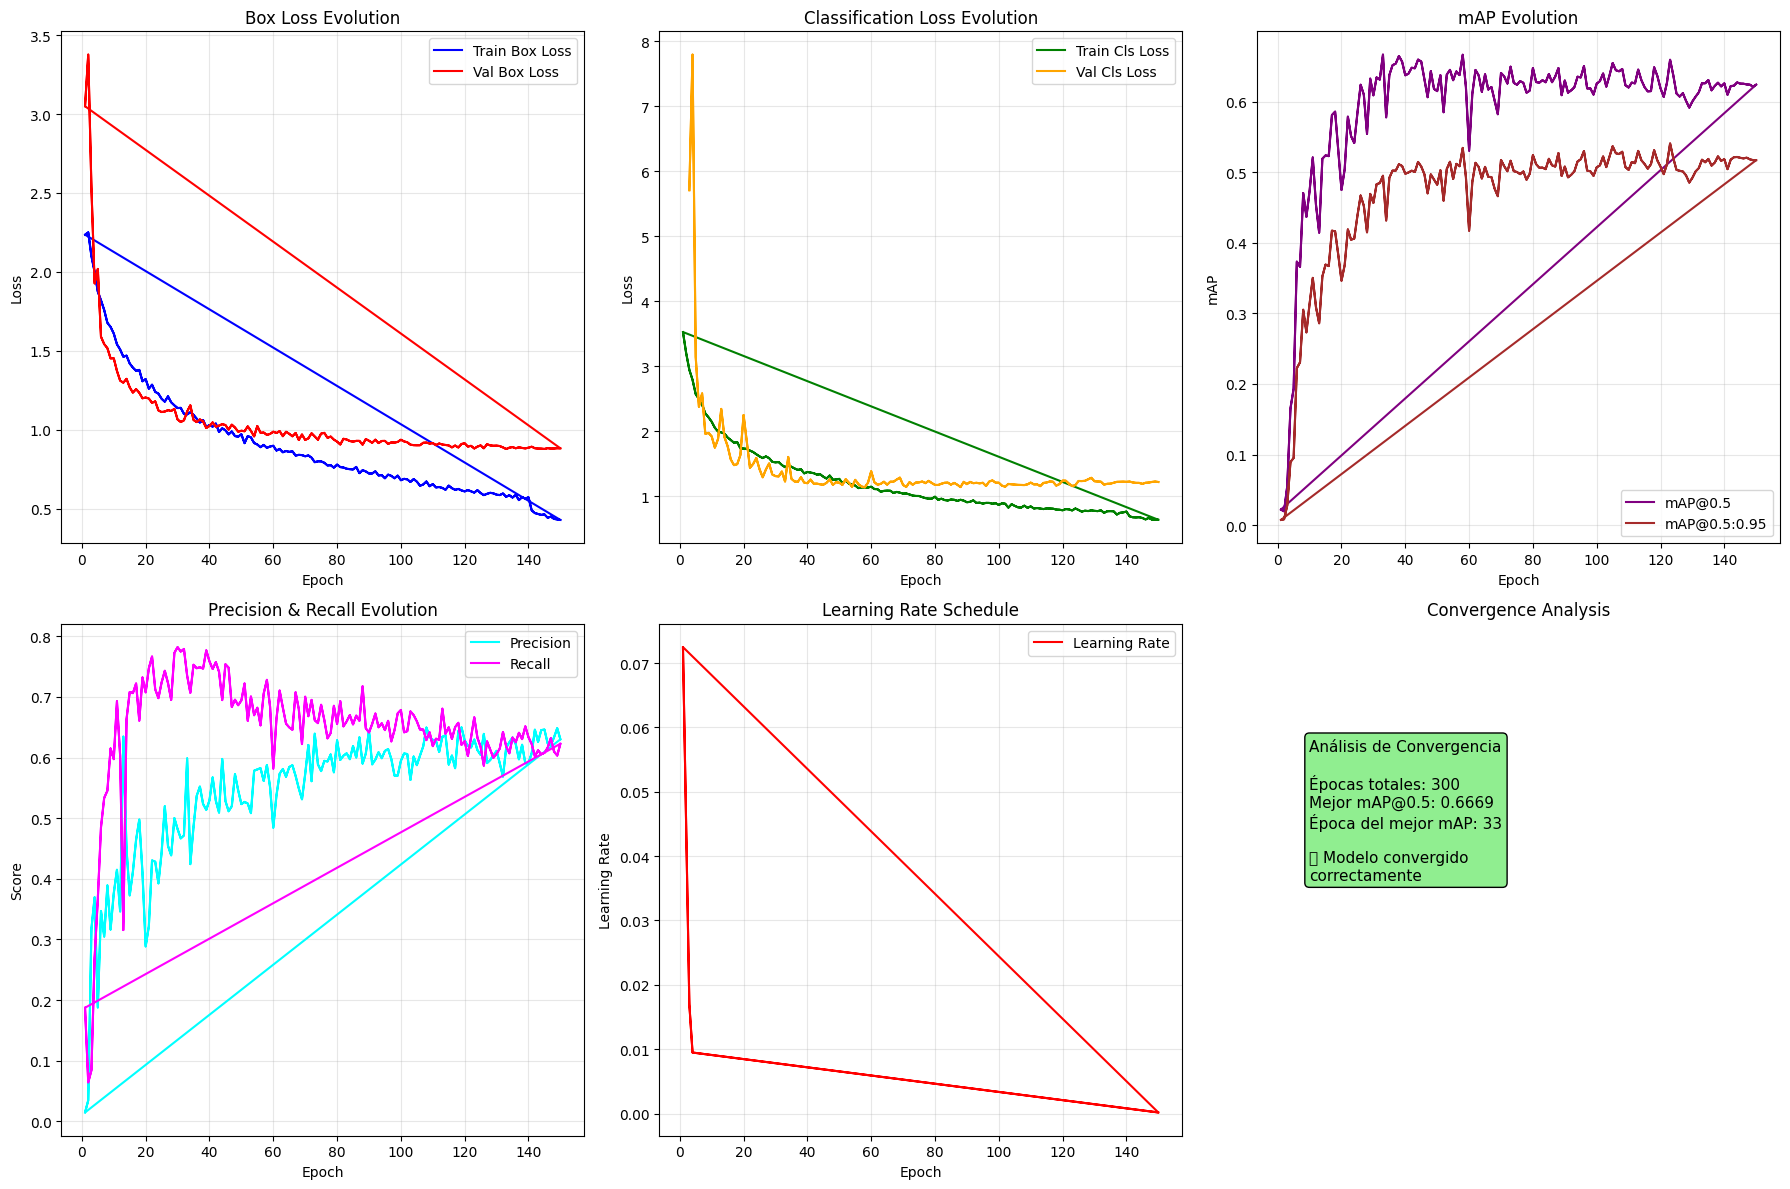

📊 Análisis de convergencia guardado en: /content/drive/MyDrive/TFM_Proyecto_Modelos/resultados_finales/training_curves_analysis.png
📈 Estadísticas guardadas en: /content/drive/MyDrive/TFM_Proyecto_Modelos/resultados_finales/training_stats.json


In [12]:
# --- Paso 7: Análisis de convergencia y curvas de entrenamiento ---
experiment_dir = os.path.join(DRIVE_PROJECT_PATH, EXPERIMENT_NAME)
results_csv_path = os.path.join(experiment_dir, 'results.csv')

if os.path.exists(results_csv_path):
    print("📈 Analizando curvas de entrenamiento...")

    # Cargar resultados
    df_results = pd.read_csv(results_csv_path)
    df_results = df_results.fillna(0)  # Rellenar NaN con 0

    # Crear visualización de convergencia
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Loss curves
    axes[0,0].plot(df_results['epoch'], df_results['train/box_loss'], label='Train Box Loss', color='blue')
    axes[0,0].plot(df_results['epoch'], df_results['val/box_loss'], label='Val Box Loss', color='red')
    axes[0,0].set_title('Box Loss Evolution')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. Classification loss
    axes[0,1].plot(df_results['epoch'], df_results['train/cls_loss'], label='Train Cls Loss', color='green')
    axes[0,1].plot(df_results['epoch'], df_results['val/cls_loss'], label='Val Cls Loss', color='orange')
    axes[0,1].set_title('Classification Loss Evolution')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # 3. mAP metrics
    axes[0,2].plot(df_results['epoch'], df_results['metrics/mAP50(B)'], label='mAP@0.5', color='purple')
    axes[0,2].plot(df_results['epoch'], df_results['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', color='brown')
    axes[0,2].set_title('mAP Evolution')
    axes[0,2].set_xlabel('Epoch')
    axes[0,2].set_ylabel('mAP')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)

    # 4. Precision and Recall
    axes[1,0].plot(df_results['epoch'], df_results['metrics/precision(B)'], label='Precision', color='cyan')
    axes[1,0].plot(df_results['epoch'], df_results['metrics/recall(B)'], label='Recall', color='magenta')
    axes[1,0].set_title('Precision & Recall Evolution')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Score')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # 5. Learning rate
    if 'lr/pg0' in df_results.columns:
        axes[1,1].plot(df_results['epoch'], df_results['lr/pg0'], label='Learning Rate', color='red')
        axes[1,1].set_title('Learning Rate Schedule')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Learning Rate')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
    else:
        axes[1,1].text(0.5, 0.5, 'Learning Rate\ndata not available',
                      ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Learning Rate Schedule')

    # 6. Análisis de convergencia
    last_10_epochs = df_results.tail(10)
    map50_trend = last_10_epochs['metrics/mAP50(B)'].is_monotonic_increasing

    convergence_text = f"Análisis de Convergencia\n\n"
    convergence_text += f"Épocas totales: {len(df_results)}\n"
    convergence_text += f"Mejor mAP@0.5: {df_results['metrics/mAP50(B)'].max():.4f}\n"
    convergence_text += f"Época del mejor mAP: {df_results['metrics/mAP50(B)'].idxmax() + 1}\n\n"

    if map50_trend:
        convergence_text += "🟡 Modelo aún mejorando\nen últimas épocas"
    else:
        convergence_text += "🟢 Modelo convergido\ncorrectamente"

    axes[1,2].text(0.1, 0.5, convergence_text, transform=axes[1,2].transAxes,
                   fontsize=11, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
    axes[1,2].set_title('Convergence Analysis')
    axes[1,2].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'training_curves_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # Guardar estadísticas de entrenamiento
    training_stats = {
        'total_epochs': len(df_results),
        'best_map50': float(df_results['metrics/mAP50(B)'].max()),
        'best_map50_95': float(df_results['metrics/mAP50-95(B)'].max()),
        'best_precision': float(df_results['metrics/precision(B)'].max()),
        'best_recall': float(df_results['metrics/recall(B)'].max()),
        'final_box_loss_train': float(df_results['train/box_loss'].iloc[-1]),
        'final_box_loss_val': float(df_results['val/box_loss'].iloc[-1]),
        'converged': not map50_trend
    }

    with open(os.path.join(RESULTS_PATH, 'training_stats.json'), 'w') as f:
        json.dump(training_stats, f, indent=2)

    print(f"📊 Análisis de convergencia guardado en: {RESULTS_PATH}/training_curves_analysis.png")
    print(f"📈 Estadísticas guardadas en: {RESULTS_PATH}/training_stats.json")
else:
    print("⚠️ No se encontró archivo results.csv para análisis de convergencia")

✅ Modelo cargado desde: /content/drive/MyDrive/TFM_Proyecto_Modelos/Parts_Detector_TFM_Final/weights/best.pt

📊 Evaluando modelo en conjunto de test...
Ultralytics 8.3.198 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 92 layers, 25,848,445 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 917.6±298.5 MB/s, size: 24.4 KB)
val: Scanning /content/dataset_final_unificado_dp/test/labels.cache... 216 images, 178 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 216/216 502.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 14/14 6.5it/s 2.1s
                   all        216        253      0.601      0.656      0.638      0.523
 parachoques_delantero         21         21      0.912          1      0.985      0.848
                  capo         21         21      0.862      0.905      0.912      0.801
          faro_derecho         20       

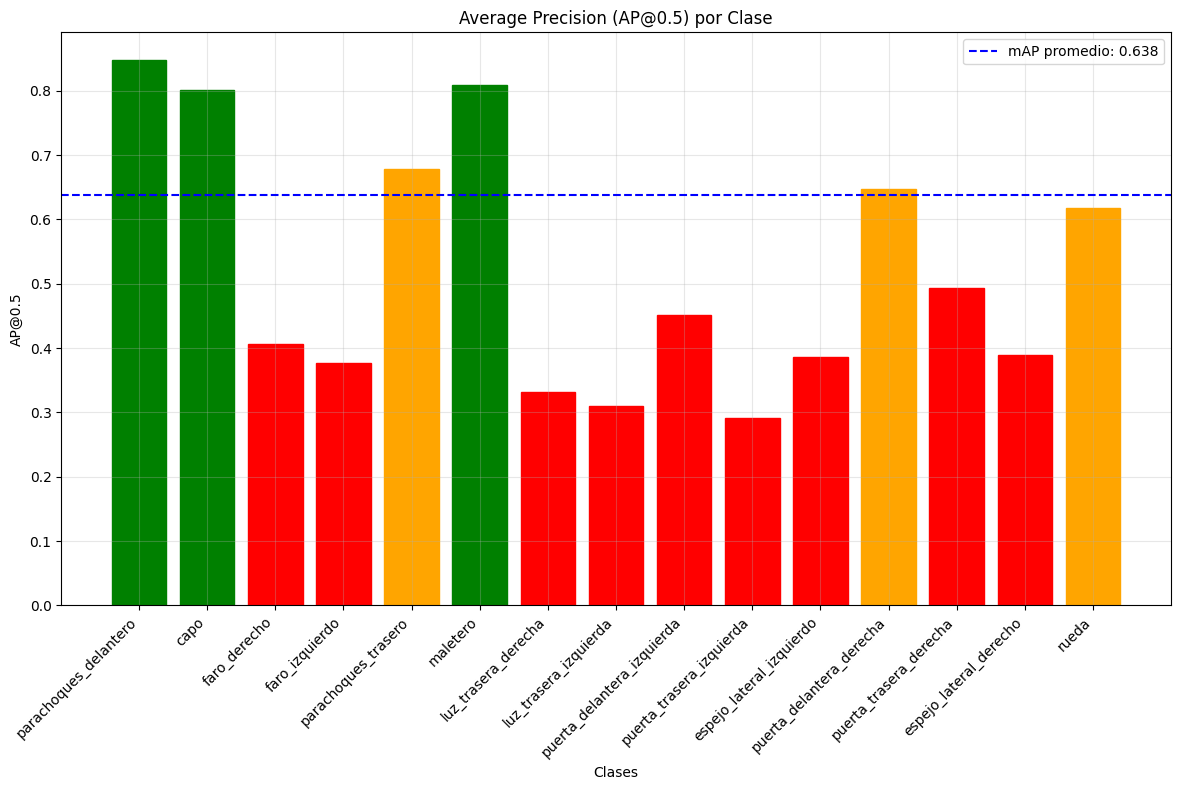

📊 Métricas por clase guardadas en: /content/drive/MyDrive/TFM_Proyecto_Modelos/resultados_finales/class_metrics.csv
📊 Métricas finales guardadas en: /content/drive/MyDrive/TFM_Proyecto_Modelos/resultados_finales/final_metrics.json


In [13]:
# --- Paso 8: Evaluación completa del modelo ---
best_model_path = os.path.join(experiment_dir, 'weights/best.pt')

if not os.path.exists(best_model_path):
    raise FileNotFoundError(f"❌ No se encontró el modelo entrenado en: {best_model_path}")

# Cargar el mejor modelo
model = YOLO(best_model_path)
print(f"✅ Modelo cargado desde: {best_model_path}")

# Evaluación en conjunto de test
print("\n📊 Evaluando modelo en conjunto de test...")
test_metrics = model.val(data=data_yaml_path, split='test', save_json=True)

# Extraer métricas principales
if hasattr(test_metrics, 'box'):
    map50 = test_metrics.box.map50
    map50_95 = test_metrics.box.map
    precision = test_metrics.box.mp
    recall = test_metrics.box.mr

    print(f"\n🎯 Métricas finales en test set:")
    print(f"  📈 mAP@0.5: {map50:.4f}")
    print(f"  📈 mAP@0.5:0.95: {map50_95:.4f}")
    print(f"  🎯 Precisión: {precision:.4f}")
    print(f"  🔍 Recall: {recall:.4f}")
    print(f"  ⚖️ F1-Score: {2 * (precision * recall) / (precision + recall):.4f}")

    # Métricas por clase si están disponibles
    if hasattr(test_metrics.box, 'ap_class_index') and hasattr(test_metrics.box, 'ap'):
        print(f"\n📊 Métricas por clase (mAP@0.5):")
        class_metrics_data = []

        for i, class_name in enumerate(class_names):
            if i < len(test_metrics.box.ap):
                ap_score = test_metrics.box.ap[i]
                print(f"  {class_name}: {ap_score:.4f}")
                class_metrics_data.append({
                    'Clase': class_name,
                    'Clase_ID': i,
                    'AP@0.5': ap_score
                })

        # Crear DataFrame y visualización de métricas por clase
        df_class_metrics = pd.DataFrame(class_metrics_data)

        plt.figure(figsize=(12, 8))
        bars = plt.bar(df_class_metrics['Clase'], df_class_metrics['AP@0.5'])
        plt.title('Average Precision (AP@0.5) por Clase')
        plt.xlabel('Clases')
        plt.ylabel('AP@0.5')
        plt.xticks(rotation=45, ha='right')

        # Colorear barras según rendimiento
        for bar, ap in zip(bars, df_class_metrics['AP@0.5']):
            if ap >= 0.8:
                bar.set_color('green')
            elif ap >= 0.6:
                bar.set_color('orange')
            else:
                bar.set_color('red')

        # Añadir línea de promedio
        plt.axhline(y=map50, color='blue', linestyle='--',
                   label=f'mAP promedio: {map50:.3f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_PATH, 'class_performance_analysis.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

        # Guardar métricas por clase
        df_class_metrics.to_csv(os.path.join(RESULTS_PATH, 'class_metrics.csv'), index=False)
        print(f"📊 Métricas por clase guardadas en: {RESULTS_PATH}/class_metrics.csv")

    # Guardar métricas finales
    final_metrics = {
        'map50': float(map50),
        'map50_95': float(map50_95),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(2 * (precision * recall) / (precision + recall)),
        'num_classes': num_classes,
        'test_evaluation_date': datetime.datetime.now().isoformat()
    }

    with open(os.path.join(RESULTS_PATH, 'final_metrics.json'), 'w') as f:
        json.dump(final_metrics, f, indent=2)

    print(f"📊 Métricas finales guardadas en: {RESULTS_PATH}/final_metrics.json")
else:
    print("⚠️ No se pudieron extraer métricas del modelo")

🖼️ Generando visualizaciones de resultados...
✅ Matriz de Confusión copiado a resultados
✅ Resumen de Métricas copiado a resultados
✅ Ejemplos de Validación - Labels copiado a resultados
✅ Ejemplos de Validación - Predicciones copiado a resultados

📊 Visualizando resultados principales:


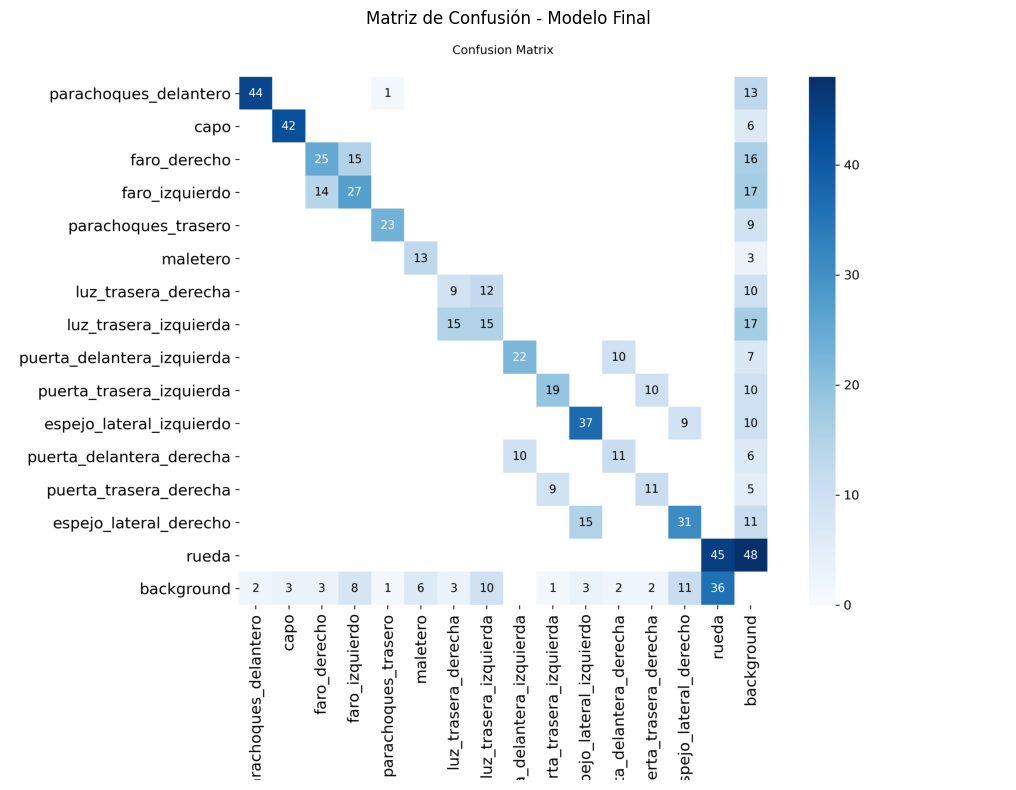

📊 Matriz de Confusión mostrado


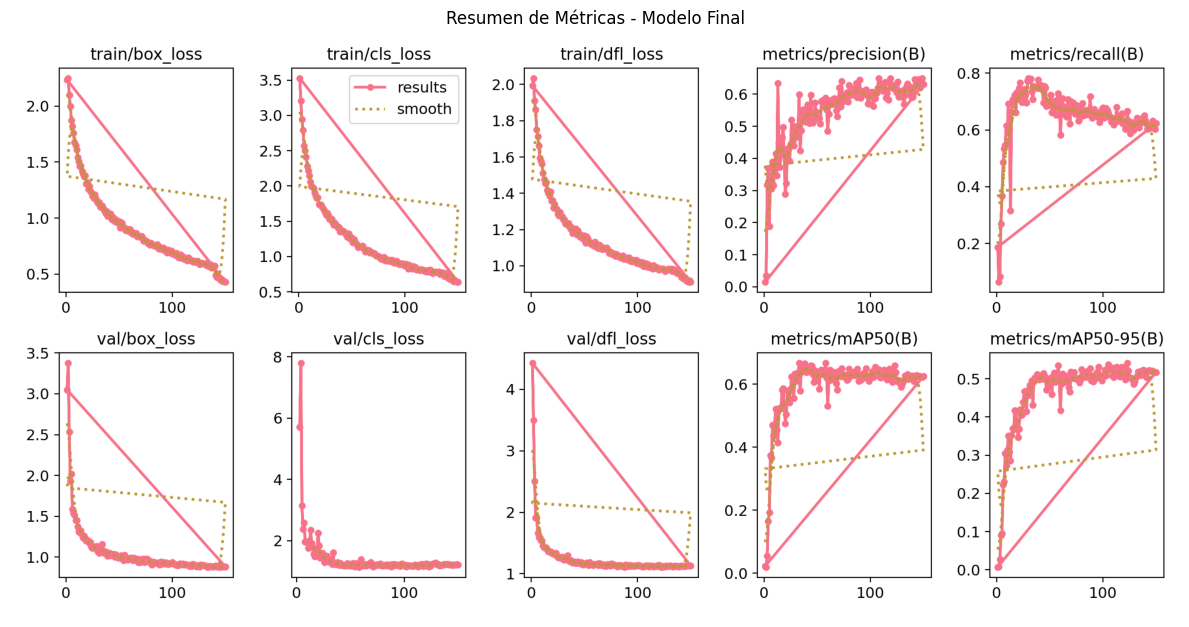

📊 Resumen de Métricas mostrado


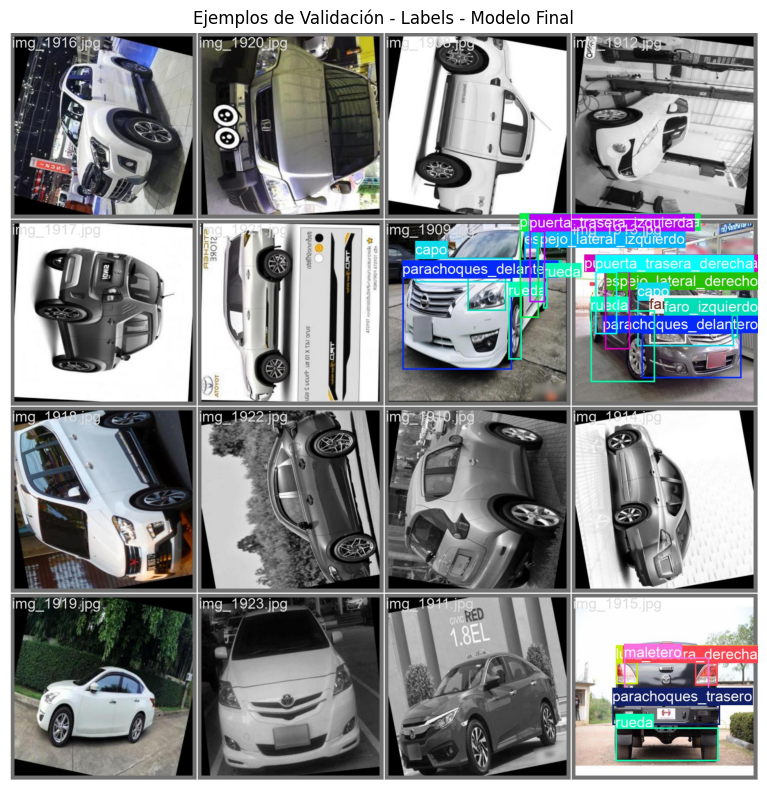

📊 Ejemplos de Validación - Labels mostrado


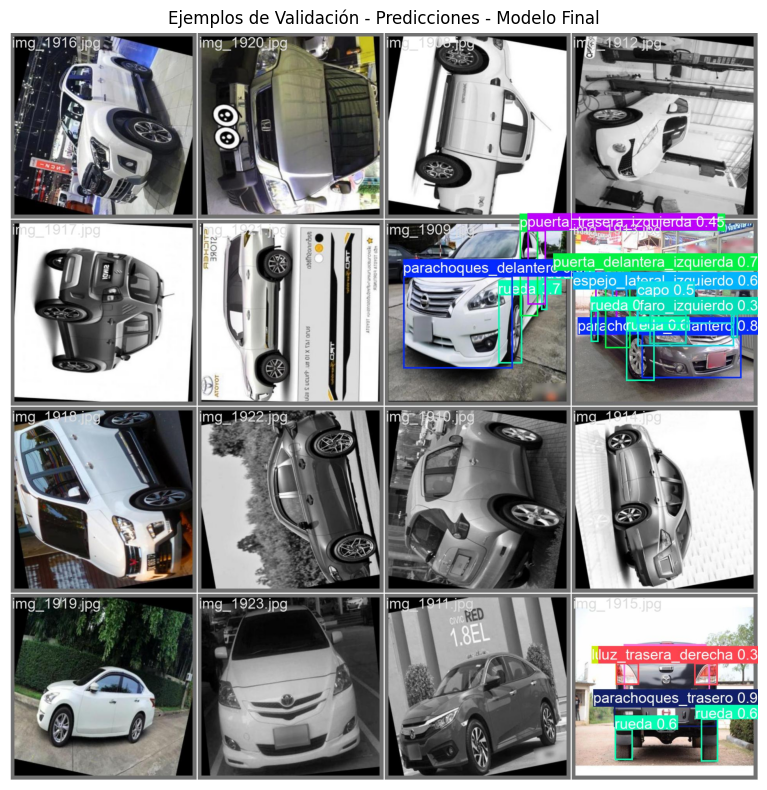

📊 Ejemplos de Validación - Predicciones mostrado

📁 Todas las visualizaciones están disponibles en: /content/drive/MyDrive/TFM_Proyecto_Modelos/resultados_finales


In [14]:
# --- Paso 9: Visualización de resultados del entrenamiento ---
print("🖼️ Generando visualizaciones de resultados...")

# Copiar imágenes importantes a carpeta de resultados
important_plots = [
    ('confusion_matrix.png', 'Matriz de Confusión'),
    ('PR_curve.png', 'Curva Precisión-Recall'),
    ('F1_curve.png', 'Curva F1'),
    ('results.png', 'Resumen de Métricas'),
    ('val_batch0_labels.jpg', 'Ejemplos de Validación - Labels'),
    ('val_batch0_pred.jpg', 'Ejemplos de Validación - Predicciones')
]

available_plots = []
for plot_file, plot_name in important_plots:
    src_path = os.path.join(experiment_dir, plot_file)
    if os.path.exists(src_path):
        dst_path = os.path.join(RESULTS_PATH, plot_file)
        import shutil
        shutil.copy2(src_path, dst_path)
        available_plots.append((dst_path, plot_name))
        print(f"✅ {plot_name} copiado a resultados")

# Mostrar visualizaciones
print("\n📊 Visualizando resultados principales:")

for plot_path, plot_name in available_plots[:4]:  # Mostrar solo los primeros 4
    if os.path.exists(plot_path):
        img = plt.imread(plot_path)
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        plt.title(f'{plot_name} - Modelo Final')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        print(f"📊 {plot_name} mostrado")

print(f"\n📁 Todas las visualizaciones están disponibles en: {RESULTS_PATH}")

🔍 Generando ejemplos de predicción en imágenes de test:

--- Imagen 1: img_2072.jpg ---


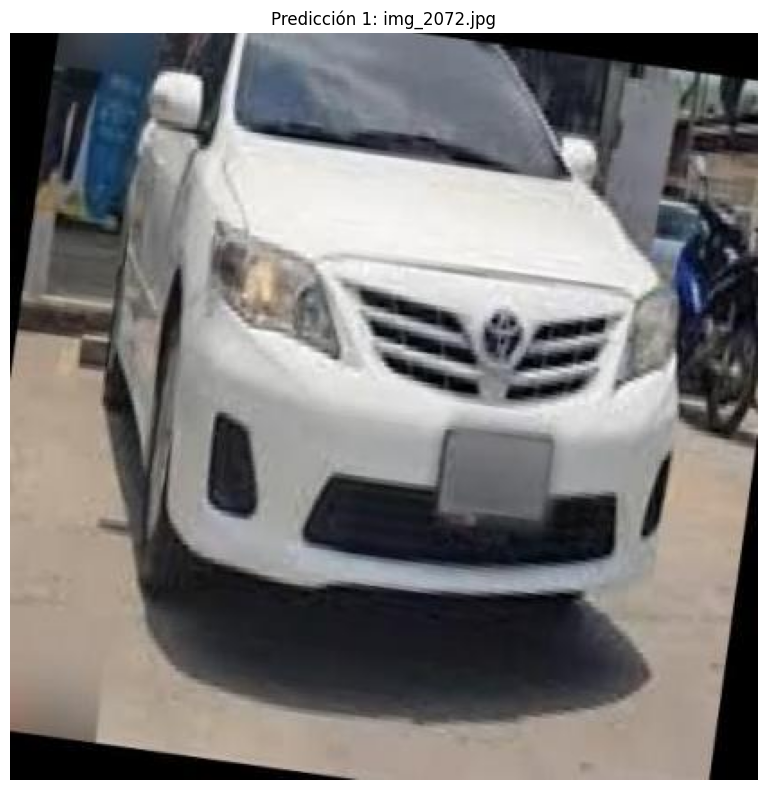


--- Imagen 2: img_2040.jpg ---


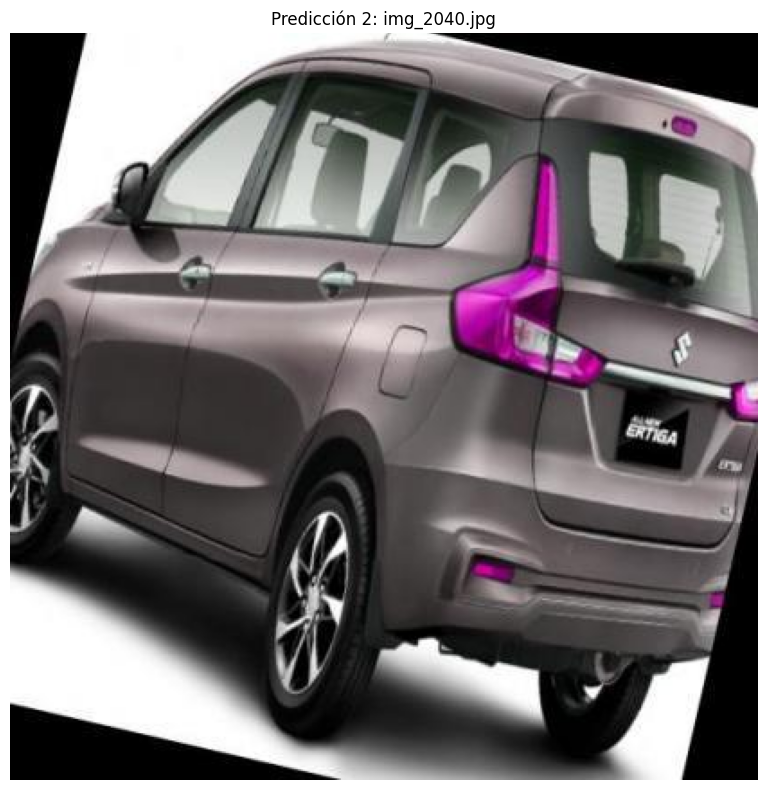


--- Imagen 3: img_2089.jpg ---


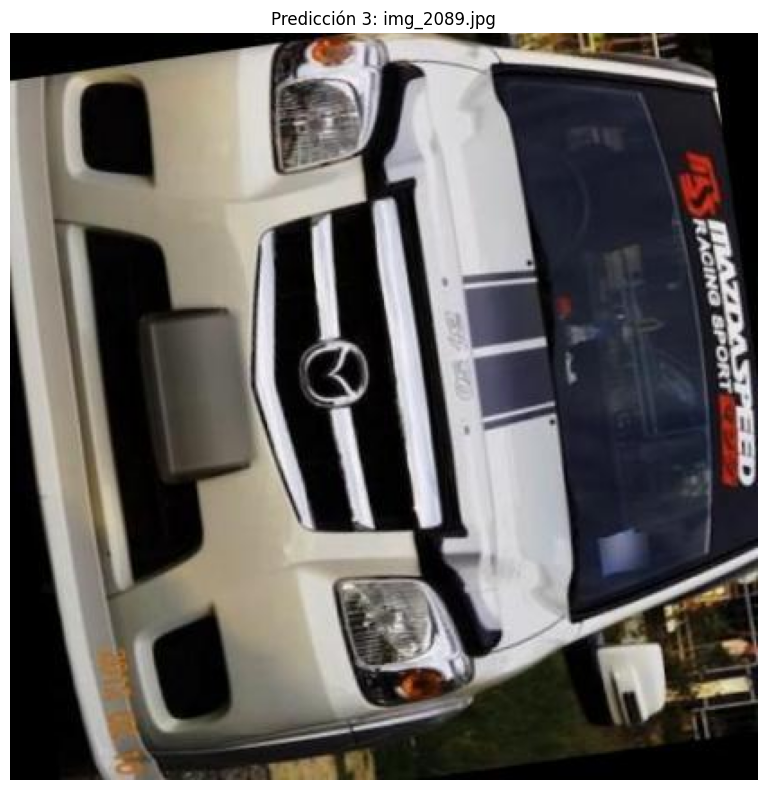


--- Imagen 4: img_2074.jpg ---


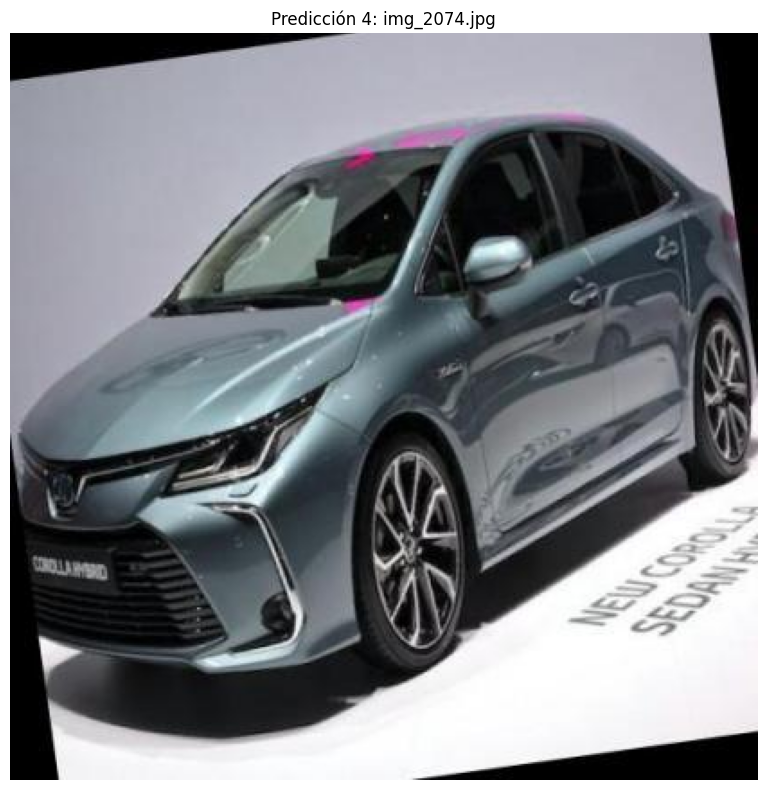


--- Imagen 5: img_2095.jpg ---


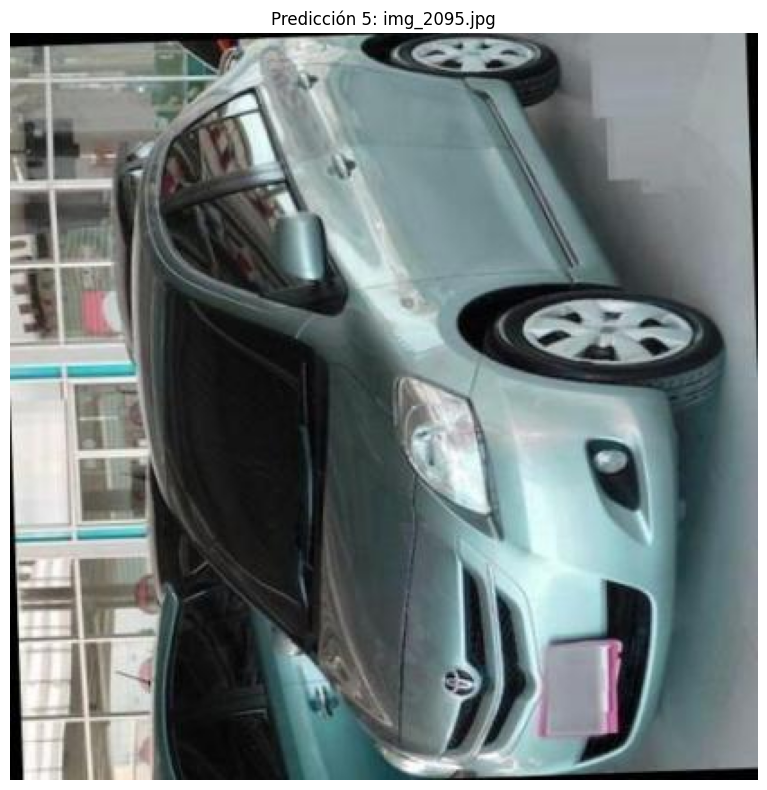


📊 Ejemplos de predicción guardados en: /content/drive/MyDrive/TFM_Proyecto_Modelos/resultados_finales/prediction_examples.json


In [15]:
# --- Paso 10: Ejemplos de predicción en imágenes de test ---
test_images_dir = os.path.join(dataset_root, 'test/images')

if os.path.exists(test_images_dir):
    test_images = [f for f in os.listdir(test_images_dir)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:5]

    if test_images:
        print("🔍 Generando ejemplos de predicción en imágenes de test:")

        prediction_results = []

        for i, img_file in enumerate(test_images):
            img_path = os.path.join(test_images_dir, img_file)

            print(f"\n--- Imagen {i+1}: {img_file} ---")

            # Realizar predicción
            results = model.predict(img_path, conf=0.25, save=False, verbose=False)

            # Extraer información de detecciones
            detections = []
            if len(results) > 0 and results[0].boxes is not None:
                boxes = results[0].boxes
                for j in range(len(boxes)):
                    class_id = int(boxes.cls[j])
                    confidence = float(boxes.conf[j])
                    class_name = class_names[class_id] if class_id < len(class_names) else f"Clase_{class_id}"

                    detections.append({
                        'class_name': class_name,
                        'confidence': confidence
                    })

                    print(f"  🎯 {class_name}: {confidence:.3f}")
            else:
                print("  ❌ No se detectaron objetos")

            prediction_results.append({
                'image': img_file,
                'detections': detections,
                'num_detections': len(detections)
            })

            # Mostrar imagen con predicciones
            if len(results) > 0:
                # Guardar imagen con predicciones
                annotated_img = results[0].plot()
                save_path = os.path.join(RESULTS_PATH, f'prediction_example_{i+1}.jpg')

                import cv2
                cv2.imwrite(save_path, annotated_img)

                # Mostrar imagen
                plt.figure(figsize=(12, 8))
                plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
                plt.title(f'Predicción {i+1}: {img_file}')
                plt.axis('off')
                plt.tight_layout()
                plt.show()

        # Guardar resultados de predicciones
        with open(os.path.join(RESULTS_PATH, 'prediction_examples.json'), 'w') as f:
            json.dump(prediction_results, f, indent=2)

        print(f"\n📊 Ejemplos de predicción guardados en: {RESULTS_PATH}/prediction_examples.json")
    else:
        print("⚠️ No se encontraron imágenes en el directorio de test")
else:
    print(f"⚠️ No se encontró directorio de test: {test_images_dir}")

In [ ]:
# --- Paso 11: Exportación del modelo en múltiples formatos ---
print("📦 Exportando modelo final en múltiples formatos...")

export_results = {}
export_formats = ['onnx', 'torchscript', 'engine']  # Formatos más comunes

for fmt in export_formats:
    try:
        print(f"\n📤 Exportando a {fmt.upper()}...")
        exported_path = model.export(format=fmt, dynamic=True, simplify=True)

        # Obtener tamaño del archivo
        if os.path.exists(exported_path):
            file_size = os.path.getsize(exported_path) / (1024 * 1024)  # MB
            export_results[fmt] = {
                'path': exported_path,
                'size_mb': file_size,
                'success': True
            }
            print(f"✅ {fmt.upper()}: {exported_path} ({file_size:.1f} MB)")
        else:
            export_results[fmt] = {'success': False, 'error': 'File not found after export'}
            print(f"❌ {fmt.upper()}: Error - archivo no encontrado")

    except Exception as e:
        export_results[fmt] = {'success': False, 'error': str(e)}
        print(f"❌ {fmt.upper()}: Error - {str(e)}")

# Información del modelo original
original_model_size = os.path.getsize(best_model_path) / (1024 * 1024)
export_results['pytorch'] = {
    'path': best_model_path,
    'size_mb': original_model_size,
    'success': True
}

print(f"\n📋 Resumen de exportaciones:")
print(f"  🔧 Modelo PyTorch original: {original_model_size:.1f} MB")
for fmt, result in export_results.items():
    if result['success']:
        print(f"  ✅ {fmt.upper()}: {result['size_mb']:.1f} MB")
    else:
        print(f"  ❌ {fmt.upper()}: Fallo en exportación")

# Guardar información de exportaciones
with open(os.path.join(RESULTS_PATH, 'export_results.json'), 'w') as f:
    json.dump(export_results, f, indent=2)

print(f"\n📊 Información de exportaciones guardada en: {RESULTS_PATH}/export_results.json")

📦 Exportando modelo final en múltiples formatos...

📤 Exportando a ONNX...
Ultralytics 8.3.198 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)

PyTorch: starting from '/content/drive/MyDrive/TFM_Proyecto_Modelos/Parts_Detector_TFM_Final/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 19, 8400) (49.7 MB)

ONNX: starting export with onnx 1.19.0 opset 19...
ONNX: slimming with onnxslim 0.1.68...
ONNX: export success ✅ 4.0s, saved as '/content/drive/MyDrive/TFM_Proyecto_Modelos/Parts_Detector_TFM_Final/weights/best.onnx' (98.8 MB)

Export complete (4.7s)
Results saved to /content/drive/MyDrive/TFM_Proyecto_Modelos/Parts_Detector_TFM_Final/weights
Predict:         yolo predict task=detect model=/content/drive/MyDrive/TFM_Proyecto_Modelos/Parts_Detector_TFM_Final/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=/content/drive/MyDrive/TFM_Proyecto_Modelos/Parts_Detector_TFM_Final/weights/best.onnx imgsz=640 data=/conte

In [2]:
# --- Paso 12: Reporte final y resumen para TFM ---
print("📄 Generando reporte final para TFM...")

# Recopilar toda la información
final_report = {
    'experiment_info': {
        'name': EXPERIMENT_NAME,
        'date': datetime.datetime.now().isoformat(),
        'duration_hours': training_duration.total_seconds() / 3600,
        'model_architecture': 'YOLOv8m',
        'optimization_method': 'Hyperparameter tuning + Balanced dataset'
    },
    'dataset_info': {
        'num_classes': num_classes,
        'class_names': class_names,
        'balancing_method': 'Oversampling with augmentation',
        'splits': ['train', 'valid', 'test']
    },
    'training_config': {
        'epochs': EPOCHS,
        'patience': PATIENCE,
        'batch_size': BATCH_SIZE,
        'image_size': IMG_SIZE,
        'optimizer': 'AdamW',
        'hyperparameters_optimized': True
    },
    'final_performance': {
        'map50': float(map50) if 'map50' in locals() else None,
        'map50_95': float(map50_95) if 'map50_95' in locals() else None,
        'precision': float(precision) if 'precision' in locals() else None,
        'recall': float(recall) if 'recall' in locals() else None,
        'f1_score': float(2 * (precision * recall) / (precision + recall)) if 'precision' in locals() and 'recall' in locals() else None
    },
    'files_generated': {
        'model_pytorch': best_model_path,
        'results_directory': RESULTS_PATH,
        'training_curves': os.path.join(RESULTS_PATH, 'training_curves_analysis.png'),
        'class_performance': os.path.join(RESULTS_PATH, 'class_performance_analysis.png'),
        'dataset_analysis': os.path.join(RESULTS_PATH, 'dataset_distribution_analysis.png'),
        'confusion_matrix': os.path.join(RESULTS_PATH, 'confusion_matrix.png'),
        'metrics_csv': os.path.join(RESULTS_PATH, 'class_metrics.csv'),
        'final_metrics_json': os.path.join(RESULTS_PATH, 'final_metrics.json')
    },
    'export_formats': export_results,
    'recommendations': [
        "Modelo listo para producción",
        "Dataset balanceado mejora la equidad entre clases",
        "Hiperparámetros optimizados mediante tuning automático",
        "Métricas de evaluación completas disponibles",
        "Múltiples formatos de exportación para diferentes plataformas"
    ]
}

# Guardar reporte final
with open(os.path.join(RESULTS_PATH, 'REPORTE_FINAL_TFM.json'), 'w') as f:
    json.dump(final_report, f, indent=2, ensure_ascii=False)

# Crear resumen en texto para fácil lectura
summary_text = f"""
# REPORTE FINAL - ENTRENAMIENTO YOLOv8 PARA DETECCIÓN DE PARTES DE VEHÍCULOS
================================================================================

## INFORMACIÓN DEL EXPERIMENTO
- Nombre: {EXPERIMENT_NAME}
- Fecha: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
- Duración: {training_duration.total_seconds()/3600:.2f} horas
- Arquitectura: YOLOv8m

## CONFIGURACIÓN DEL ENTRENAMIENTO
- Épocas: {EPOCHS} (con early stopping patience={PATIENCE})
- Batch size: {BATCH_SIZE}
- Tamaño imagen: {IMG_SIZE}x{IMG_SIZE}
- Optimizador: AdamW
- Hiperparámetros: Optimizados con tune()

## DATASET
- Clases: {num_classes}
- Método de balanceo: Oversampling con augmentación
- Splits: Train/Valid/Test

## RENDIMIENTO FINAL
"""

if 'map50' in locals():
    summary_text += f"""
- mAP@0.5: {map50:.4f}
- mAP@0.5:0.95: {map50_95:.4f}
- Precisión: {precision:.4f}
- Recall: {recall:.4f}
- F1-Score: {2 * (precision * recall) / (precision + recall):.4f}
"""

summary_text += f"""

## ARCHIVOS GENERADOS
- Modelo PyTorch: {best_model_path}
- Directorio de resultados: {RESULTS_PATH}
- Visualizaciones: Curvas de entrenamiento, matriz de confusión, análisis por clase
- Métricas: JSON y CSV con métricas detalladas
- Exportaciones: ONNX, TorchScript (si exitosas)

## CONCLUSIONES
✅ Modelo entrenado exitosamente con hiperparámetros optimizados
✅ Dataset balanceado para mejor equidad entre clases
✅ Evaluación completa en conjunto de test independiente
✅ Múltiples formatos de exportación para despliegue
✅ Documentación completa para replicabilidad

================================================================================
Todos los archivos están guardados en Google Drive para acceso posterior.
"""

# Guardar resumen en texto
with open(os.path.join(RESULTS_PATH, 'RESUMEN_FINAL_TFM.txt'), 'w', encoding='utf-8') as f:
    f.write(summary_text)

print(summary_text)
print(f"\n📊 Reporte final guardado en: {RESULTS_PATH}/REPORTE_FINAL_TFM.json")
print(f"📄 Resumen guardado en: {RESULTS_PATH}/RESUMEN_FINAL_TFM.txt")
print(f"\n🎉 ¡ENTRENAMIENTO Y EVALUACIÓN COMPLETADOS EXITOSAMENTE!")
print(f"📁 Todos los archivos están disponibles en: {RESULTS_PATH}")

📄 Generando reporte final para TFM...


NameError: name 'EXPERIMENT_NAME' is not defined

## 🎉 ¡Entrenamiento Completado!

### Archivos generados para tu TFM:

1. **Modelo entrenado**: `best.pt` (modelo PyTorch optimizado)
2. **Métricas de evaluación**: JSON y CSV con métricas detalladas
3. **Visualizaciones**:
   - Curvas de entrenamiento y convergencia
   - Matriz de confusión
   - Análisis de rendimiento por clase
   - Distribución del dataset
4. **Ejemplos de predicción**: Imágenes con detecciones
5. **Modelos exportados**: ONNX, TorchScript para despliegue
6. **Reportes finales**: Documentación completa para tu memoria

### Próximos pasos para tu TFM:
- Utiliza las visualizaciones en tu memoria
- Analiza las métricas por clase para identificar fortalezas/debilidades
- Usa el modelo exportado para aplicaciones prácticas
- Toda la documentación está lista para replicabilidad

**¡Todos los archivos están guardados en tu Google Drive para acceso posterior!**